## **Imports**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from scipy.stats import chi2_contingency, f_oneway
from collections import Counter
from copy import deepcopy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

## **Loading Data and Preview**

In [46]:
data = pd.read_csv("data.csv")
test = pd.read_csv('test.csv')
data.head()

,message,fingers,tail,species
0,pluvia arbor aquos,4,no,Aquari
1,cosmix xeno nebuz odbitaz,5,yes,Zorblax
2,solarix glixx novum galaxum quasar,5,yes,Zorblax
3,arbor insectus pesros ekos dootix nimbus,2,yes,Florian
4,mermax drakos lorix epikoz deftax,4,no,Faerix


In [47]:
data_info = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  500 non-null    object
 1   fingers  500 non-null    int64 
 2   tail     500 non-null    object
 3   species  500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


In [48]:
data['tail'] = data['tail'].replace({'yes': 1, 'no': 0})
test['tail'] = test['tail'].replace({'yes': 1, 'no': 0})

# **Data Analysis**

### **Tail v/s Species**

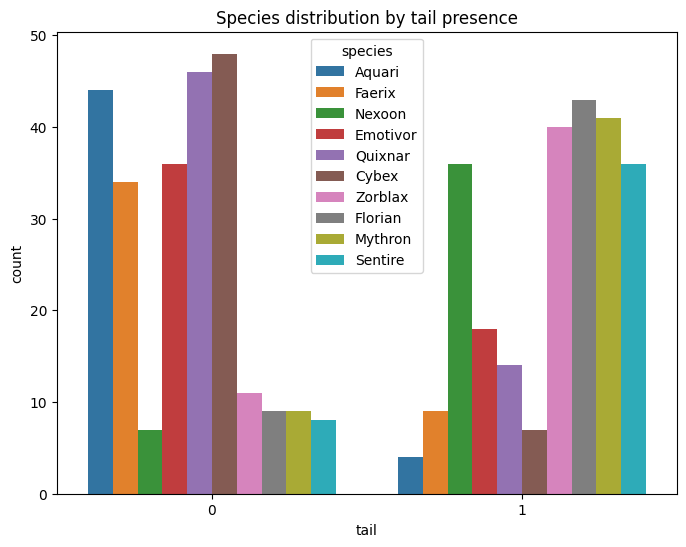

In [5]:
plt.figure(figsize=(8,6))
sns.countplot(x='tail', hue='species', data=data)
plt.title("Species distribution by tail presence")
plt.show()

In [6]:
#Chi-Square Test
contingency_table = pd.crosstab(data['tail'], data['species'])
chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)
p_chi2

8.463656461328298e-38

**We obtained a very low p-score, indicating significant dependency on presence of tail and specie columns. Based on this, we might consider increasing weightage of tail columns later.**

### **Fingers v/s Species**

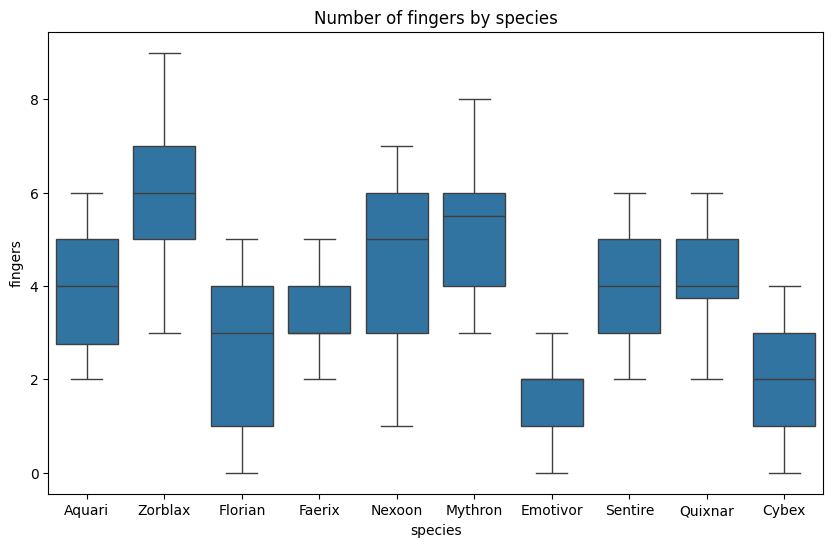

In [7]:
plt.figure(figsize=(10,6))
sns.boxplot(x='species', y='fingers', data=data)
plt.title("Number of fingers by species")
plt.show()

In [8]:
#Annova Testing
groups = [data['fingers'][data['species'] == specie] for specie in data['species'].unique()]
f_stat, p_anova = f_oneway(*groups)
print(p_anova)

1.1515022111208446e-77


**This is also very low, indicating high relation between fingers and species as well.**

### **Words v/s Species**

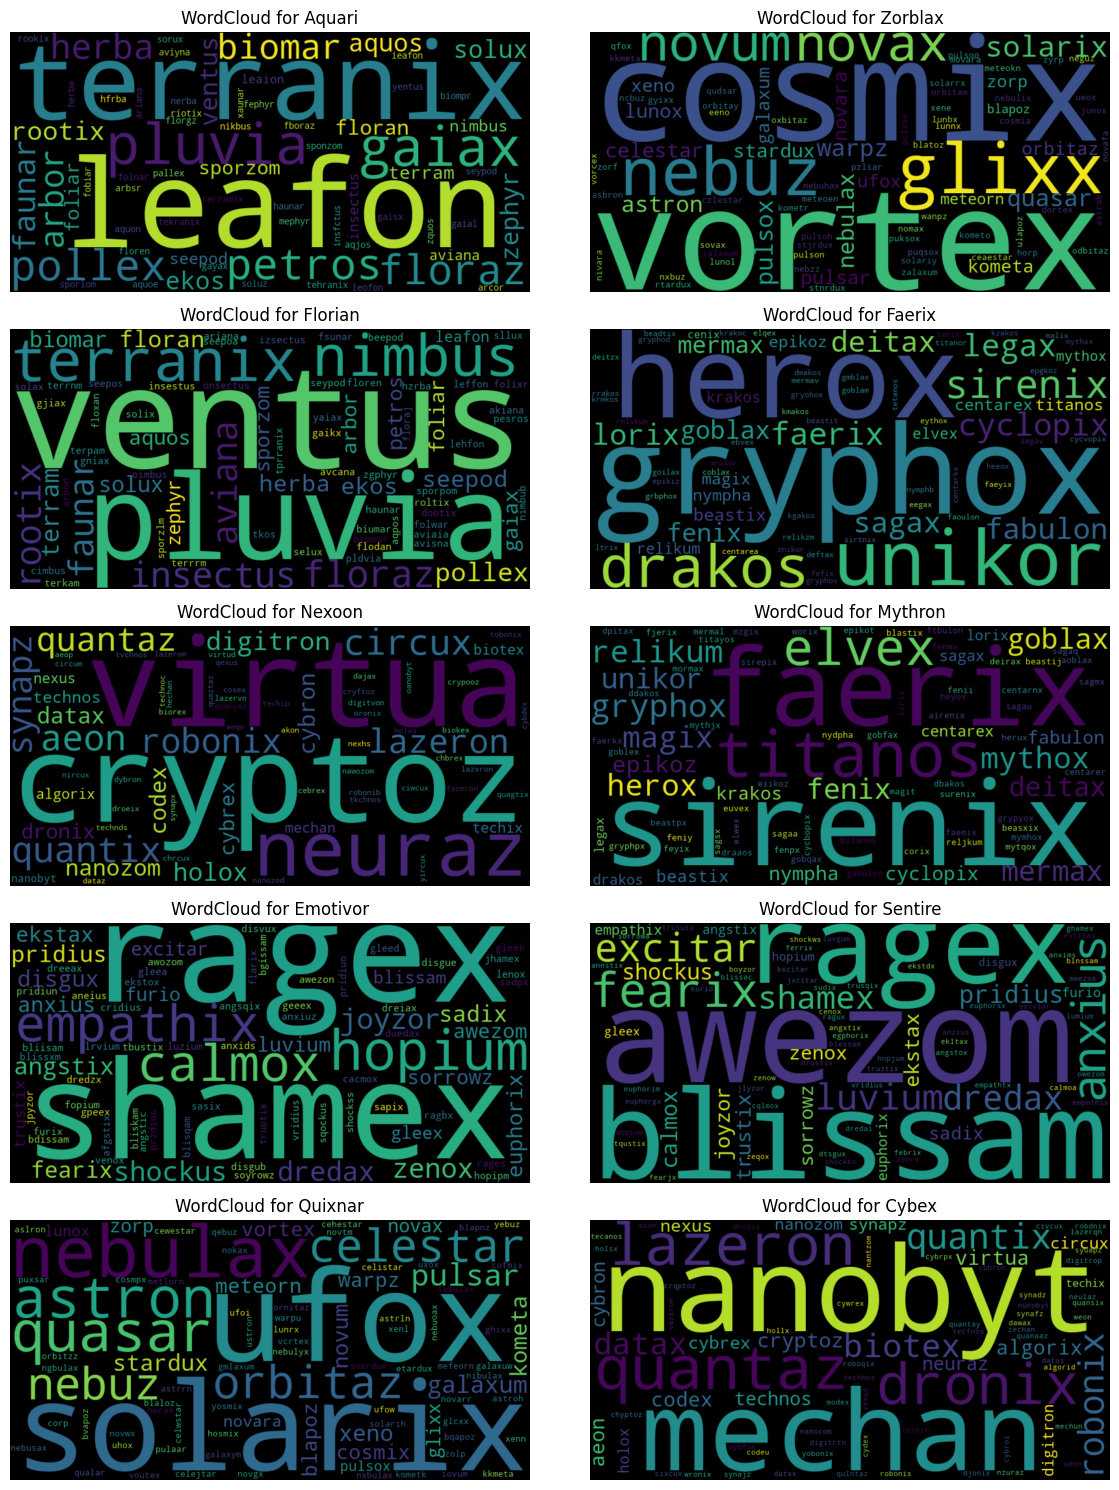

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

n_cols = 2
n_rows = (len(data['species'].unique()) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 3))

axes = axes.flatten()
wordclouds = {}

for idx, specie in enumerate(data['species'].unique()):
    text = ' '.join(data['message'][data['species'] == specie])
    wordclouds[specie] = WordCloud(width=800, height=400).generate(text)
    
    axes[idx].imshow(wordclouds[specie], interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f"WordCloud for {specie}")

for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


**As we can see, there are certain words which imply high probabibility of the message being from a certain specie.**

**We want to generate new columns for presence/absence of those word**

## **Data Reformatting**

### **Creating new columns for two most common words for each species**

In [11]:
commons = set()

for specie in data['species'].unique():
    text = ' '.join(data['message'][data['species'] == specie])
    word_counts = Counter(text.split())
    most_common = word_counts.most_common(2)
    for word in most_common:
        commons.add(word[0])

commons = list(commons)
print(len(commons), commons)

20 ['gryphox', 'awezom', 'pluvia', 'herox', 'cryptoz', 'leafon', 'shamex', 'vortex', 'blissam', 'sirenix', 'virtua', 'ventus', 'faerix', 'mechan', 'ufox', 'solarix', 'nanobyt', 'cosmix', 'ragex', 'terranix']


In [49]:
df = deepcopy(data)
test_df = deepcopy(test)
for word in commons:
    df[word] = df['message'].apply(lambda x: 2 if word in x.split() else 0)
    test_df[word] = test_df['message'].apply(lambda x: 2 if word in x.split() else 0)


In [13]:
df.head()

,message,fingers,tail,species,gryphox,awezom,pluvia,herox,cryptoz,leafon,...,virtua,ventus,faerix,mechan,ufox,solarix,nanobyt,cosmix,ragex,terranix
0,pluvia arbor aquos,4,0,Aquari,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,cosmix xeno nebuz odbitaz,5,1,Zorblax,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
2,solarix glixx novum galaxum quasar,5,1,Zorblax,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
3,arbor insectus pesros ekos dootix nimbus,2,1,Florian,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,mermax drakos lorix epikoz deftax,4,0,Faerix,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## **Training**

In [19]:
vectorizer = TfidfVectorizer(max_features=124)  # Limiting features to 100
X_message = vectorizer.fit_transform(data['message']).toarray()


X_fingers = data['fingers'].values.reshape(-1, 1)
X_tail = data['tail'].astype(int).values.reshape(-1, 1)


X = np.concatenate([X_message] + [X_fingers, X_tail] * 4, axis=1)


le = LabelEncoder()
y = le.fit_transform(data['species'])
species_mapping = {index: species for index, species in enumerate(le.classes_)}


In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [41]:
clf = RandomForestClassifier(n_estimators=900, random_state=20)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=900, random_state=20)

In [42]:
y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.96


#### **We are able to receive an accuracy of 96% on the validation set.**

#### **Now we'll train on the complete data and predict on the rows in the test.csv file**

In [43]:
clf.fit(X, y)

RandomForestClassifier(n_estimators=900, random_state=20)

## **Predicting on test.csv**

In [21]:
species_mapping = {index: species for index, species in enumerate(le.classes_)}
print(species_mapping)

{0: 'Aquari', 1: 'Cybex', 2: 'Emotivor', 3: 'Faerix', 4: 'Florian', 5: 'Mythron', 6: 'Nexoon', 7: 'Quixnar', 8: 'Sentire', 9: 'Zorblax'}


In [52]:
test_fingers = test['fingers'].values.reshape(-1, 1)
test_tail = test['tail'].astype(int).values.reshape(-1, 1)

In [53]:
X_test = np.concatenate([vectorizer.fit_transform(test['message']).toarray()] +  [test_fingers, test_tail] * 4, axis=1)


In [54]:
y_pred = clf.predict(X_test)


In [55]:
y_pred

array([1, 8, 4, 7, 6, 5, 3, 3, 2, 4, 5, 2, 9, 7, 5, 0, 4, 2, 0, 0, 9, 2,
       7, 6, 5, 6, 0, 8, 2, 5, 1, 2, 5, 7, 3, 1, 0, 4, 0, 7, 0, 7, 5, 6,
       0, 2, 4, 7, 9, 4, 2, 5, 8, 7, 2, 2, 9, 2, 5, 1, 1, 1, 5, 8, 8, 5,
       8, 3, 6, 7, 7, 2, 4, 9, 2, 8, 1, 3, 2, 2, 2, 1, 2, 7, 7, 8, 3, 9,
       2, 3, 9, 5, 7, 7, 8, 4, 5, 6, 2, 8, 1, 8, 8, 0, 6, 6, 0, 2, 7, 2,
       2, 5, 0, 5, 0, 7, 5, 1, 3, 7, 5, 8, 1, 1, 7, 4, 1, 4, 7, 9, 6, 7,
       3, 0, 8, 2, 1, 6, 6, 5, 1, 0, 3, 8, 9, 7, 2, 8, 0, 6, 2, 2, 0, 2,
       0, 8, 0, 9, 4, 2, 2, 0, 2, 1, 9, 2, 0, 4, 5, 1, 5, 8, 9, 2, 1, 8,
       4, 8, 4, 2, 2, 5, 7, 3, 3, 7, 2, 1, 6, 7, 8, 9, 5, 9, 1, 1, 5, 3,
       1, 6, 6, 3, 8, 4, 5, 7, 5, 0, 7, 3, 5, 3, 9, 1, 0, 2, 0, 3, 6, 9,
       0, 8, 6, 2, 4, 8, 2, 5, 0, 6, 3, 7, 7, 3, 1, 8, 1, 1, 3, 9, 7, 6,
       5, 8, 7, 4, 4, 2, 0, 1, 5, 2, 4, 9, 3, 7, 0, 3, 1, 9, 5, 3, 9, 3,
       9, 5, 6, 4, 9, 9, 1, 7, 2, 3, 3, 7, 5, 4, 1, 0, 8, 8, 8, 1, 2, 0,
       1, 0, 7, 1, 8, 2, 2, 4, 3, 6, 5, 7, 2])

In [56]:
output = pd.read_csv('test.csv')
output['species'] = [species_mapping[x] for x in y_pred]

In [57]:
output.head()

,message,fingers,tail,species
0,iephyr terram nimbus terram faunar foliar,2,no,Cybex
1,joyzor uleex luvium caloox shockus blissae,4,yes,Sentire
2,aquos arbor ventuc,4,yes,Florian
3,nympha nympha epikoz nympha mythox mythox mythox,3,no,Quixnar
4,diitax sibenix fabulon,4,yes,Nexoon


In [60]:
output.to_csv('result.csv', index=False)